In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
from pmdarima import auto_arima, model_selection, ARIMA
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib

In [21]:
%run datatools.py

# Read endogenous and exogenous data and filter country/dates

In [3]:
# We read the endogenous data (coronavirus data)

covid_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covid = pd.read_csv(covid_url, parse_dates=['date'], index_col=['date'])

In [4]:
# We filter the country, dates and the variable to predict

country = 'Spain'
variable = 'new_cases'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
# moving intialdate by 6, since we later apply 7-day rolling mean to our data:
initialdateshift = str(date.fromordinal(datetime.strptime(initialdate, '%Y-%m-%d').toordinal() + 6)) 
enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

# Filtering country and dates
covid_ctry = covid[covid['location']==country]
covid_ctry = covid_ctry.loc[initialdate:enddate]

# Filter the variable to predict and applying 7-day rolling mean
covid_ctry_var = covid_ctry[variable]
covid_ctry_varR = covid_ctry_var.rolling(7).mean().dropna()

In [5]:
# We now read the exogenous data, which is already 7-day rolling mean (for now, from a local file)

exogenous = pd.read_csv('./data/exogenas.csv', parse_dates=[0], index_col=[0])

In [6]:
# We now need to filter the country and adjust the dates (start series on 'initialdateshift'):

exogenous_ctry = exogenous.loc[:, exogenous.columns.str.contains(country)]
exogenous_ctryR = exogenous_ctry.loc[initialdateshift:enddate]

In [7]:
# Exogenous data is forced to have last day as "yesterday". We check if covid_ctry_varR has same last day and if not, 
# we extend it to match the exogenous date range:
if len(covid_ctry_varR) < len(exogenous_ctryR):
    covid_ctry_varR = covid_ctry_varR.reindex(exogenous_ctryR.index).interpolate()

In [8]:
# We check that effectively endogenous and exogenous data have the same length:
print(len(covid_ctry_varR) == len(exogenous_ctryR))

True


# Visualize endogenous and exogenous data and normalize it all

(232,) (232, 14)


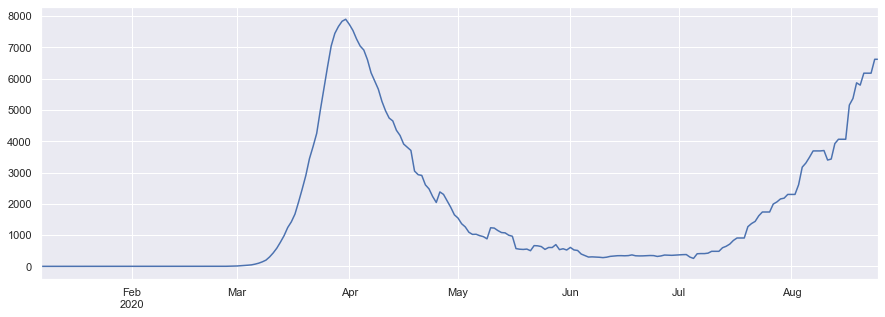

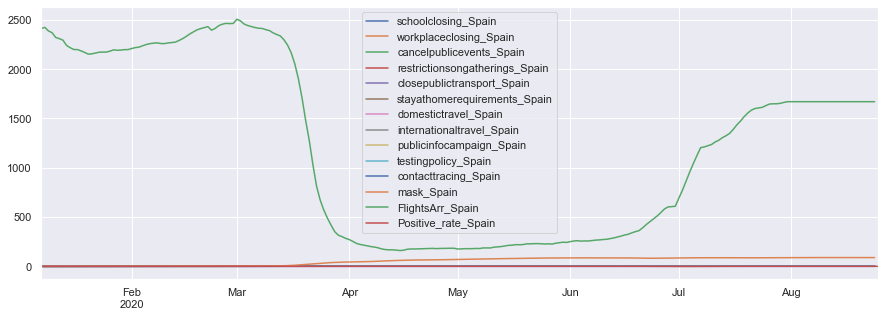

In [9]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [10]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [11]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR.values.reshape(-1,1))
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.name)
y = scaled_output.resample('1D').sum()

(232,) (232, 14)


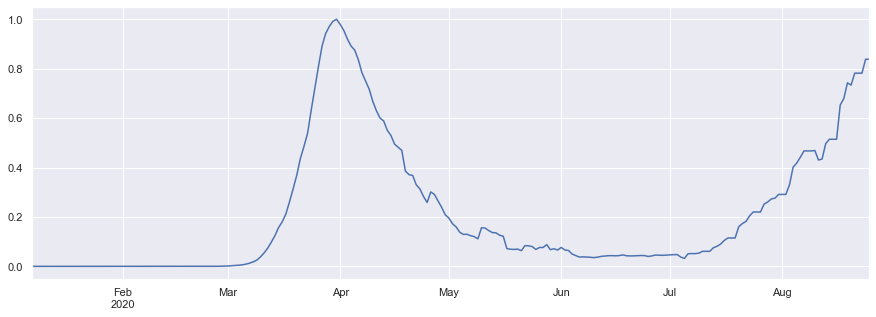

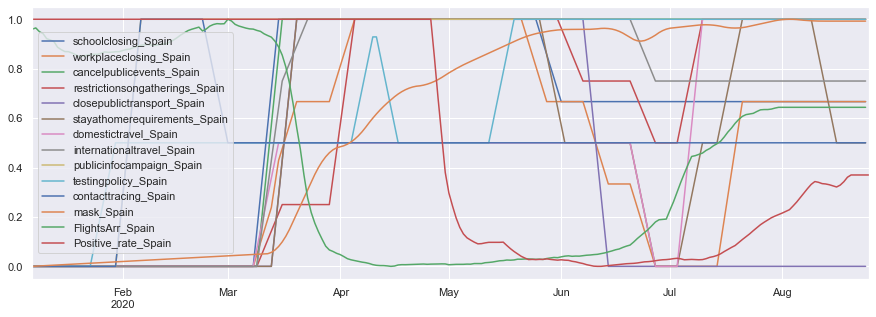

In [12]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [13]:
# We are going to use 85% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [14]:
train_size, test_size

(197, 35)

# Stationarity: estimate differencing term (d)

In [15]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  2
KPSS test:  1
PP test:  1


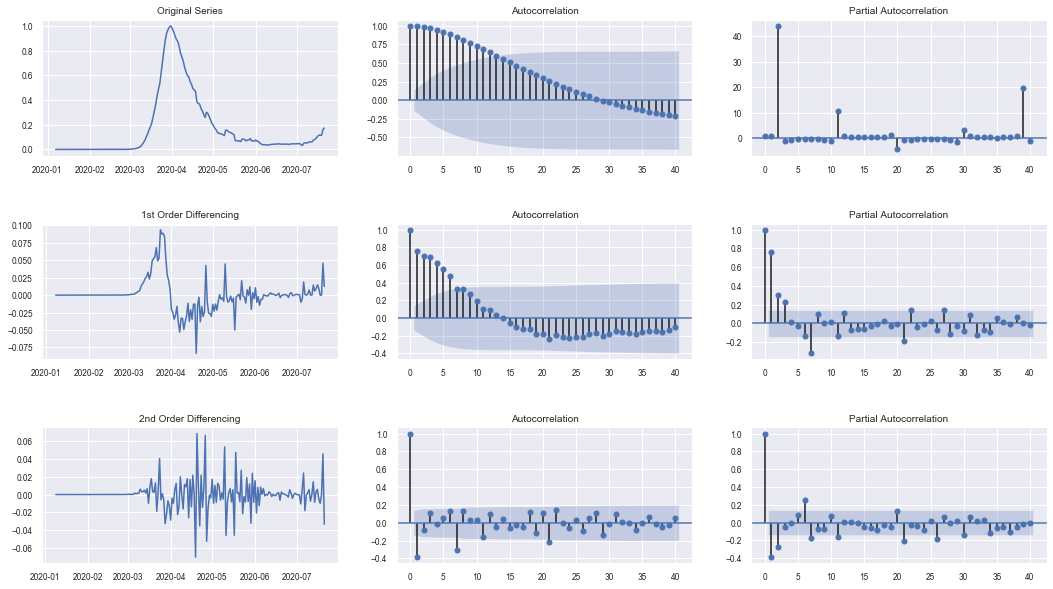

In [16]:
# Plotting ACF and PACF for different 'd' values (d=1, d=2):

plot_acf_pacf(y_train)
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

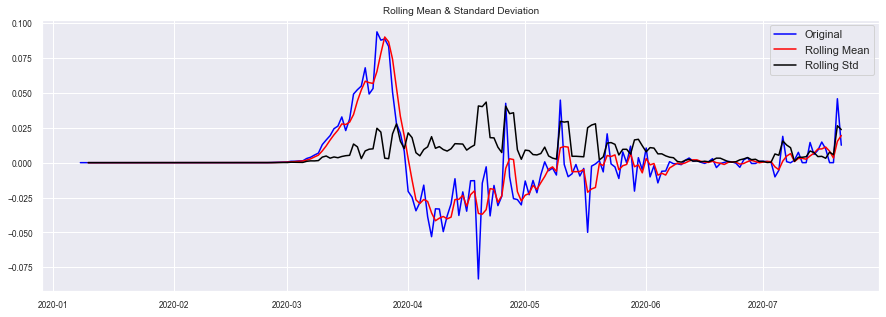

Result of Dicky-Fuller Test


Test Statistic           -3.244552
p-value                   0.017546
#Lags Used                7.000000
#Observations Used      188.000000
Critical Value (1%)      -3.465620
Critical Value (5%)      -2.877040
Critical Value (10%)     -2.575032
dtype: float64

In [17]:
# Test stationarity and print results of ADF test:
test_stationarity(y_train.diff().dropna())

# Estimate orders p and q of ARIMA model, using auto_arima

In [18]:
# Perform different auto_arima searches and sort results by lowest AIC:
result_table = autoarimas(y_train, X_train)
result_table

,parameters,aic
0,"(0, 2, 3)",-1110.696363
1,"(1, 1, 3)",-1102.943905
2,"(0, 2, 1)",-1102.387959
3,"(1, 1, 1)",-1093.562161


# Perform cross-validation on top 2 models and select the best. Then train and fit SARIMAX model with the one that gave best results

In [19]:
# Extract top 2 models from previous step (first 2 elements, since they are sorted):
model1 = ARIMA(order=result_table.iloc[0,0])
model2 = ARIMA(order=result_table.iloc[1,0])

In [22]:
best_order = cross_val(y_train, X_train, model1, model2)

Model 1 CV scores: ['93.8397', '16.1972', '116.8087', '131.8053', '200.0000', '71.7130', '175.5364', '128.6592', '184.4693']
Model 2 CV scores: ['23.7602', '100.0206', '30.8929', '25.5753', '163.6194', '154.8072', '68.1077', '158.0269', '192.7279']
Lowest average SMAPE: 101.94866318104927 (model2)
Best model order: (1, 1, 3)


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  197
Model:               SARIMAX(1, 1, 3)   Log Likelihood                 572.899
Date:                Wed, 26 Aug 2020   AIC                          -1107.797
Time:                        11:20:20   BIC                          -1045.513
Sample:                    01-07-2020   HQIC                         -1082.582
                         - 07-21-2020                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain               -0.0476      0.116     -0.410      0.682      -0.275       0.180
workplaceclosing_Spain             0.0540      0.103      0.527      0.

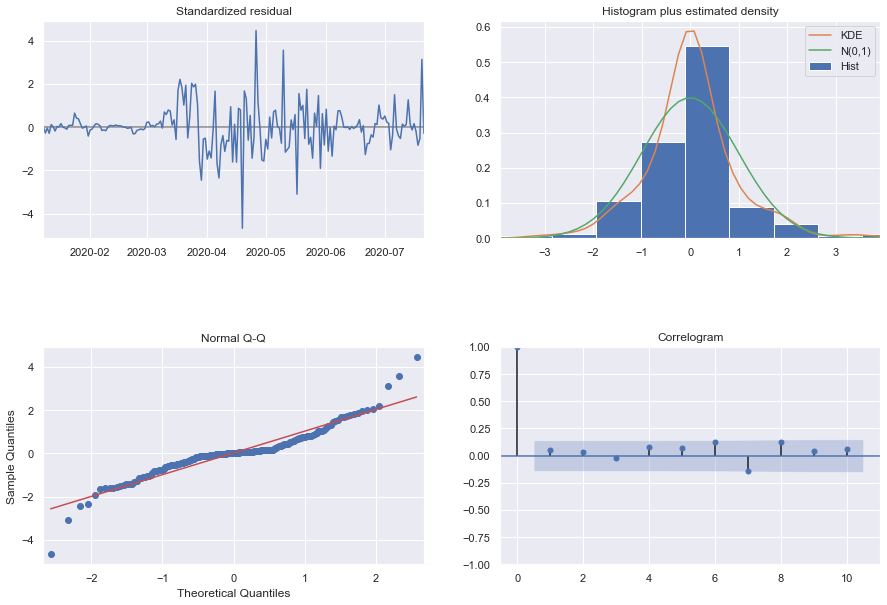

In [23]:
best_model = sm.tsa.statespace.SARIMAX(y_train, order=best_order, exog=X_train)
results = best_model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model MAE

In [24]:
train_size, test_size, X_test.shape

(197, 35, (35, 14))

In [32]:
X_test.iloc[-1,:]

schoolclosing_Spain                   NaN
workplaceclosing_Spain                NaN
cancelpublicevents_Spain              NaN
restrictionsongatherings_Spain        NaN
closepublictransport_Spain            NaN
stayathomerequirements_Spain          NaN
domestictravel_Spain                  NaN
internationaltravel_Spain             NaN
publicinfocampaign_Spain              NaN
testingpolicy_Spain                   NaN
contacttracing_Spain                  NaN
mask_Spain                            NaN
FlightsArr_Spain                      NaN
Positive_rate_Spain               0.36978
Name: 2020-08-25 00:00:00, dtype: float64

In [25]:
in_out_fcast_plot(results, test_size, y, y_test, X_train, X_test)

# set title and show plot
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.show()

MissingDataError: exog contains inf or nans

# Scale data back to original values

In [232]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.name)

In [233]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.name)

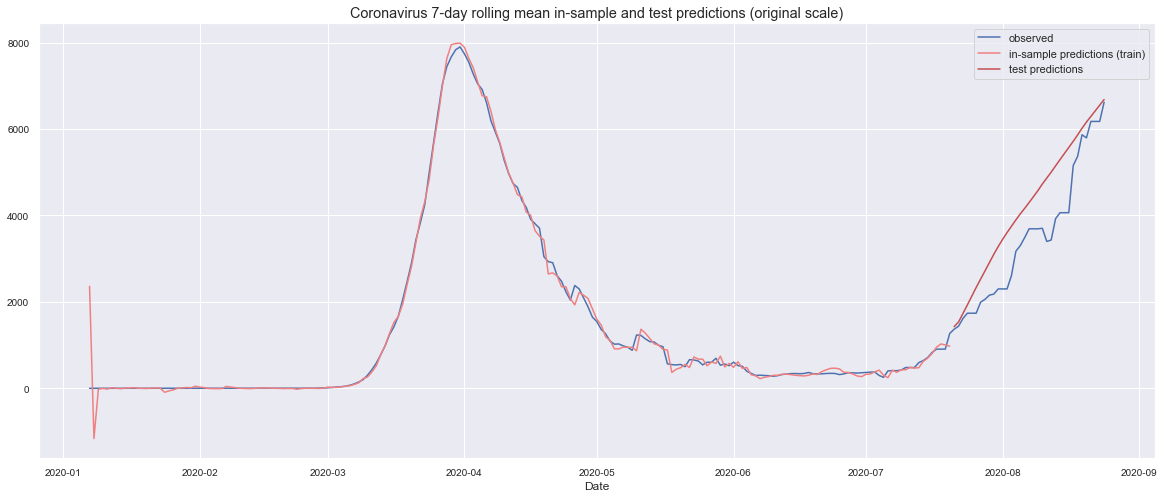

In [234]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

In [235]:
print("Test MAE (original scale): %.3f" % np.sqrt(mean_absolute_error(covid_ctry_varR[train_size:], testPredictS)))

Test MAE (original scale): 26.749


# Save model so we can then update with future values

In [183]:
%pwd

'C:\\Users\\marta\\Documents\\MasterDataScience\\project\\KSchool-Master-Final-Project'

In [236]:
# Set model name
filename = './models/SpainSARIMAXmodel.pkl'

# Pickle it
joblib.dump(results, filename)

['./models/SpainSARIMAXmodel.pkl']

In [237]:
# Load the model back in
loaded_model = joblib.load(filename)

In [238]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  196
Model:               SARIMAX(0, 2, 3)   Log Likelihood                 571.293
Date:                Tue, 25 Aug 2020   AIC                          -1106.587
Time:                        22:52:15   BIC                          -1047.765
Sample:                    01-07-2020   HQIC                         -1082.768
                         - 07-20-2020                                         
Covariance Type:                  opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain               -0.0190      0.093     -0.205      0.838      -0.201       0.163
workplaceclosing_Spain             0.0551      0.083      0.661      0.509      -0.108       0.219
cancelpublicevents_Spain           0.1919      0.201      0.954      0.340      -0.202       0.586
restrictionsongatherings_Spain    -0.0878      0.070     -1.247      0.213      -0.226       0.050
closepublictransport_Spain        -0.0323      0.104     -0.310      0.756      -0.236       0.172
stayathomerequirements_Spain      -0.0305      0.088     -0.347      0.728      -0.203       0.142
domestictravel_Spain               0.0876      0.078      1.126      0.260      -0.065       0.240
internationaltravel_Spain         -0.2418      0.255     -0.948      0.343      -0.742       0.258
publicinfocampaign_Spain          -0.0768      1.826     -0.042      0.966      -3.655       3.502
testingpolicy_Spain               -0.1612      0.040     -4.060      0.000      -0.239      -0.083
contacttracing_Spain               0.0346      1.821      0.019      0.985      -3.535       3.604
mask_Spain                         1.9076      0.397      4.810      0.000       1.130       2.685
FlightsArr_Spain                   0.1381      0.204      0.678      0.498      -0.261       0.537
Positive_rate_Spain                0.1662      0.061      2.706      0.007       0.046       0.287
ma.L1                             -0.6278      0.058    -10.794      0.000      -0.742      -0.514
ma.L2                             -0.0188      0.066     -0.285      0.776      -0.148       0.110
ma.L3                              0.2706      0.062      4.369      0.000       0.149       0.392
sigma2                             0.0002   1.38e-05     11.679      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       54.83   Jarque-Bera (JB):               126.50
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):              17.95   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Update model with test observations, to get it ready for future forecasts

In [239]:
# Update model with test sample and re-fit parameters:
res_updated = results.append(y_test, exog=X_test, refit=True)

                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  231
Model:               SARIMAX(0, 2, 3)   Log Likelihood                 596.646
Date:                Tue, 25 Aug 2020   AIC                          -1157.292
Time:                        22:52:20   BIC                          -1095.485
Sample:                    01-07-2020   HQIC                         -1132.358
                         - 08-24-2020                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
schoolclosing_Spain                0.0092      0.153      0.060      0.952      -0.291       0.309
workplaceclosing_Spain             0.0346      0.165      0.210      0.

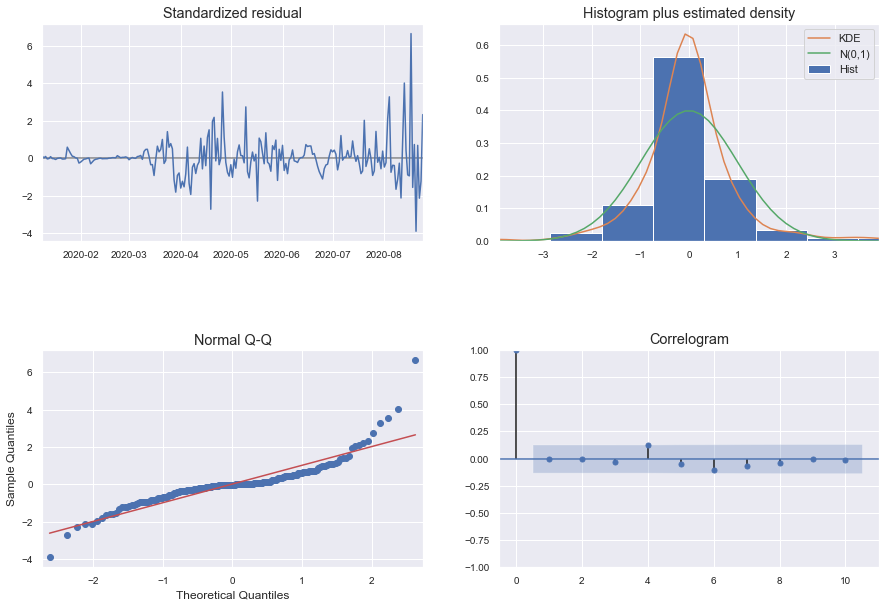

In [240]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

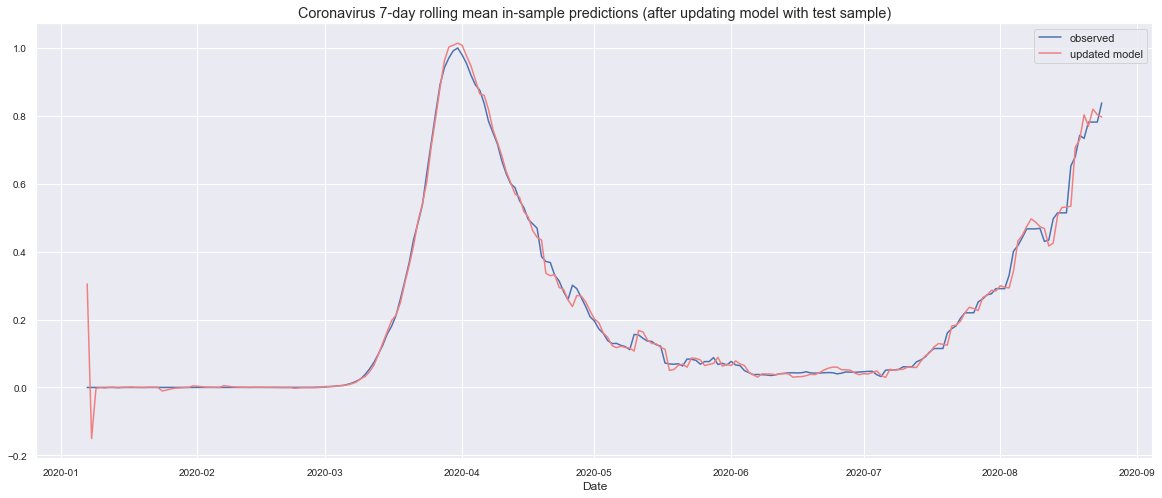

In [241]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [242]:
# Save model again, after updating it with test sample:
#filename = './SpainSARIMAXmodel2.pkl'

# Pickle it
joblib.dump(res_updated, filename)

['./models/SpainSARIMAXmodel.pkl']

# Perform forecast

In [243]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdateshift, new_date, freq='D')
exog_conc = exogenous_ctryR.reindex(new_index).interpolate()

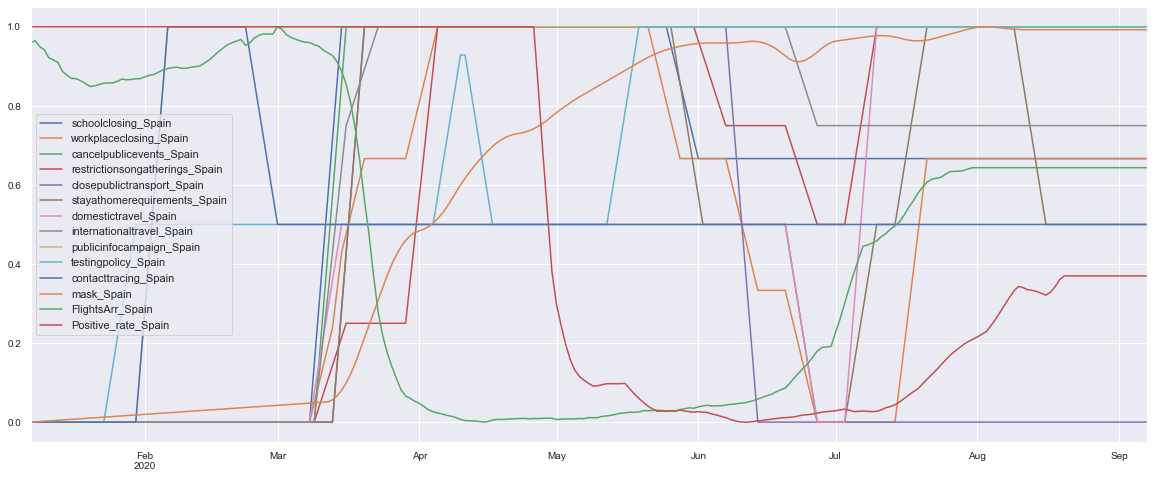

In [244]:
# Re-scale exogenous date with new added days:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[0.8615536  0.88495852 0.91152524 0.93809197 0.9646587  0.99122542
 1.01779215 1.04435888 1.0709256  1.09749233 1.12405905 1.15062578
 1.17719251 1.20375923]


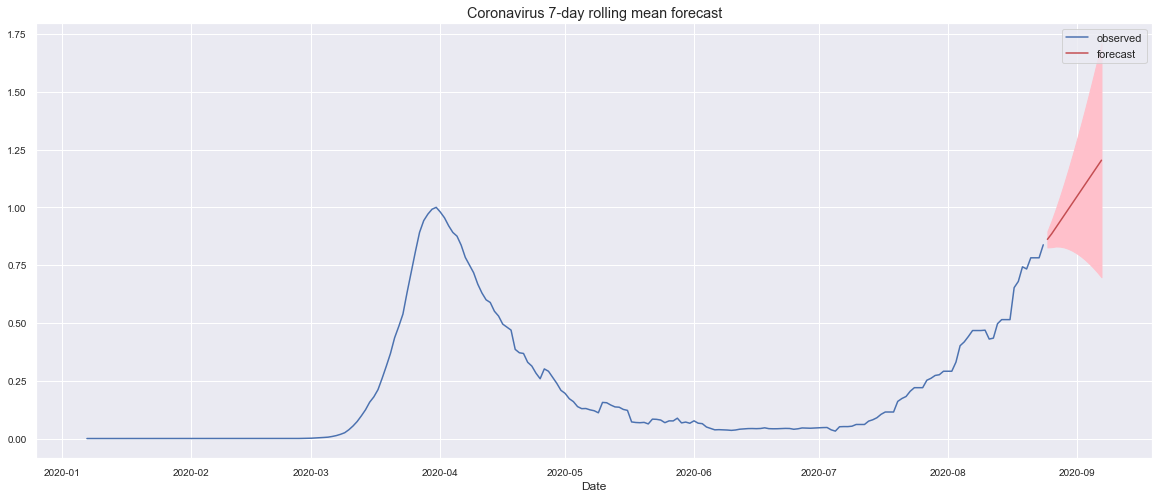

In [245]:
# Generate out of sample forecast

forecast = res_updated.get_forecast(steps=forecastdays, exog=X_fc[new_begin:new_date])

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()

In [246]:
forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')

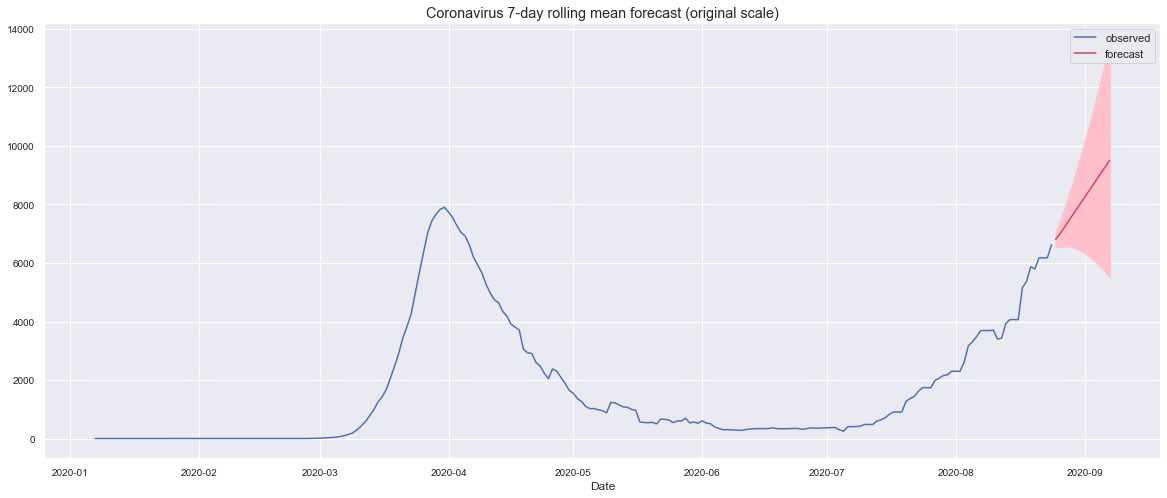

In [247]:
# plot the data
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(forecast14S.index, forecast14S, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(forecast14_llS.index, forecast14_llS, forecast14_ulS, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast (original scale)')
plt.legend()
plt.show()

In [248]:
# Print forecasted values:

forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print(forecast14S_l)

['6808.0', '6992.9', '7202.9', '7412.8', '7622.7', '7832.7', '8042.6', '8252.5', '8462.5', '8672.4', '8882.3', '9092.2', '9302.2', '9512.1']


In [195]:
sm.__version__

'0.11.1'

In [197]:
import pmdarima as pm
pm.__version__

'1.6.1'